In [1]:
# import sys
# sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [2]:
# train_prepared.to_csv("./data/train_prepared.csv")
# test_prepared.to_csv("./data/test_prepared.csv")

train_prepared = pd.read_csv("./data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("./data/test_prepared.csv", index_col=[0])

In [3]:
train_prepared.head(3)

,TARGET,date_mensuelle,DAYS_BIRTH_disc_int,EXT_SOURCE_2_disc_int,EXT_SOURCE_1_disc_int,AMT_GOODS_PRICE_disc_int,DAYS_REGISTRATION_disc_int,DAYS_LAST_PHONE_CHANGE_disc_int,EXT_SOURCE_3_disc_int,AMT_CREDIT_disc_int,...,REG_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,FLAG_WORK_PHONE,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CODE_GENDER
0,0,2013-01-01,[-13195;-7489],[0.49;0.85],[0.0;0.39],[679500.0;4050000.0],[-5735.0;0.0],[-1128.0;0.0],[0.32;0.9],[675000.0;4050000.0],...,zero,trois,trois,zero,un,zero,Cash loans,Y,Y,M
1,0,2013-01-01,[-13195;-7489],[0.49;0.85],[0.0;0.39],[40500.0;676278.0],[-5735.0;0.0],[-1128.0;0.0],[0.32;0.9],[45000.0;674842.5],...,zero,trois,trois,zero,un,zero,Cash loans,N,Y,F
2,0,2013-01-01,[-13195;-7489],[0.49;0.85],[0.0;0.39],[40500.0;676278.0],[-24672.0;-5736.0],[-1128.0;0.0],[0.32;0.9],[45000.0;674842.5],...,zero,deux,deux,un,zero,zero,Cash loans,Y,N,F


In [4]:
df_train = train_prepared.copy()
df_train.shape


(306107, 35)

# Modélisation

In [5]:
list=train_prepared.columns[-7:].tolist()
for i in list:
    print(train_prepared[i].nunique())

2
2
2
2
2
2
2


## V03

In [6]:
# Fonction pour parser les intervalles et extraire les bornes
def parse_interval(interval):
    if isinstance(interval, str):
        start, end = map(float, interval.strip('[]()').split(';'))
    elif isinstance(interval, tuple):
        start, end = interval
    else:
        raise ValueError("Interval must be either a string or a tuple")
    return start, end

from sklearn.preprocessing import LabelEncoder

def process_object_columns(df):
    # Parcourir toutes les colonnes
    for col in df.columns:
        if df[col].dtype == 'object':  # Vérifier si la colonne est de type "object"
            # Vérifier si les valeurs contiennent des crochets ou des accolades
            if any('[' in val or '{' in val for val in df[col]):
                # Convertir les intervalles en valeurs numériques
                df[col] = df[col].apply(lambda x: parse_interval(x)[0])  # Utilisez [1] pour extraire la borne supérieure
            else:
                # Encoder les modalités avec LabelEncoder
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
    return df

train_data = df_train.copy()
train_data['date_mensuelle'] = pd.to_datetime(train_data['date_mensuelle'])

train_data['date_mensuelle_numeric'] = (train_data['date_mensuelle'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')
train_data = train_data.drop(columns=['date_mensuelle'])

# Appliquer la fonction pour traiter les colonnes de type "object"
df_processed = process_object_columns(train_data)

In [7]:
df_processed

,TARGET,DAYS_BIRTH_disc_int,EXT_SOURCE_2_disc_int,EXT_SOURCE_1_disc_int,AMT_GOODS_PRICE_disc_int,DAYS_REGISTRATION_disc_int,DAYS_LAST_PHONE_CHANGE_disc_int,EXT_SOURCE_3_disc_int,AMT_CREDIT_disc_int,AMT_ANNUITY_disc_int,...,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,FLAG_WORK_PHONE,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CODE_GENDER,date_mensuelle_numeric
0,0,-13195.0,0.49,0.00,679500.0,-5735.0,-1128.0,0.32,675000.0,1615.5,...,1,1,1,0,1,0,1,1,1,15706
1,0,-13195.0,0.49,0.00,40500.0,-5735.0,-1128.0,0.32,45000.0,1615.5,...,1,1,1,0,1,0,0,1,0,15706
2,0,-13195.0,0.49,0.00,40500.0,-24672.0,-1128.0,0.32,45000.0,1615.5,...,0,0,0,1,1,0,1,0,0,15706
3,0,-19263.0,0.49,0.00,679500.0,-24672.0,-1128.0,0.32,675000.0,1615.5,...,2,2,1,1,1,0,1,1,0,15706
4,0,-19263.0,0.00,0.00,40500.0,-5735.0,-4292.0,0.32,45000.0,1615.5,...,0,0,1,0,0,0,0,0,0,15706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306102,0,-19263.0,0.00,0.39,40500.0,-5735.0,-4292.0,0.32,45000.0,1615.5,...,1,1,1,1,1,0,0,0,0,18597
306103,0,-19263.0,0.49,0.00,40500.0,-5735.0,-4292.0,0.32,45000.0,1615.5,...,0,0,1,1,0,0,0,1,0,18597
306104,0,-19263.0,0.49,0.00,679500.0,-5735.0,-1128.0,0.32,675000.0,41629.5,...,2,2,1,0,1,0,0,1,0,18597
306105,0,-25229.0,0.15,0.00,40500.0,-5735.0,-1128.0,0.32,45000.0,1615.5,...,1,1,1,1,1,0,0,1,1,18597


### logit

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# from statsmodels.formula.api import Logit
from sklearn.model_selection import train_test_split

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.formula.api import logit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sélection des fonctionnalités
features = df_processed.columns[-8:-1].tolist()

# Création du dictionnaire des catégories de référence
reference_categories = {}
for var in features:
    reference_categories[var] = df_processed[var].mode()[0]

# Créer la formule en utilisant les catégories de référence spécifiées
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        # formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')
        formula_parts.append(f'{var}')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)


# Séparation des caractéristiques (X) et de la cible (y)
X = df_processed.drop(columns=['TARGET'])
y = df_processed['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Sélection des caractéristiques les plus informatives
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# 2. Entraînement du modèle de régression logistique avec les caractéristiques sélectionnées
# Importer la classe Logit de statsmodels
from statsmodels.discrete.discrete_model import Logit

# 2. Entraînement du modèle de régression logistique avec les caractéristiques sélectionnées
model = Logit(endog=y_train, exog=X_train_selected)
logit_result = model.fit()

# 3. Prédiction sur l'ensemble de test
y_pred = logit_result.predict(X_test_selected)

# 4. Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred.round())
print("Accuracy:", accuracy)

# Afficher un résumé du modèle
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.247031
         Iterations 7
Accuracy: 0.923066871386103
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               244885
Model:                          Logit   Df Residuals:                   244855
Method:                           MLE   Df Model:                           29
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                 0.08702
Time:                        02:23:03   Log-Likelihood:                -60494.
converged:                       True   LL-Null:                       -66260.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.033e-05   2.07e-06      9.821      0.000    1.63e-05    2.44e-05
x

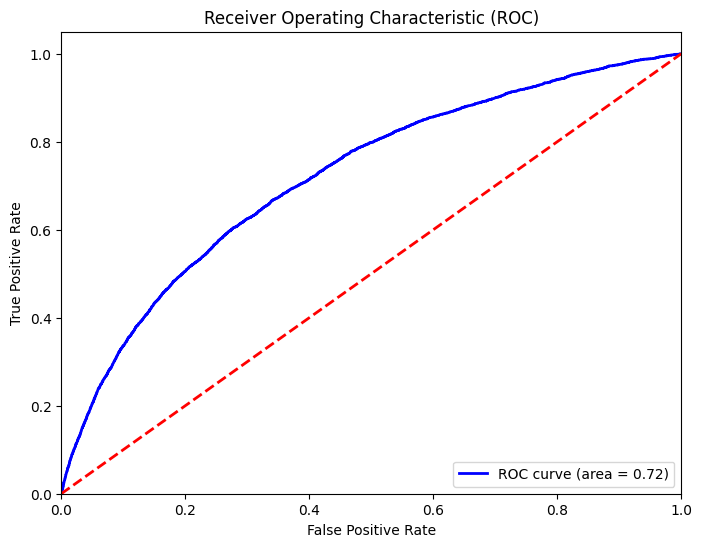

Gini Score: 0.43952342385084653


In [22]:
from sklearn.metrics import roc_curve, auc

# Calculer les probabilités prédites pour les classes positives
y_pred_proba = logit_result.predict(X_test_selected)

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calcul du score Gini
gini_score = 2 * roc_auc - 1
print("Gini Score:", gini_score)

# Gini Score: 0.4163273479384617(k=10)
# Gini Score: 0.4285703784841859(k=20)
# Gini Score: 0.43952342385084653(k=30)


In [24]:
from sklearn.metrics import confusion_matrix

# Convertir les probabilités prédites en classes binaires (0 ou 1)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Afficher la matrice de confusion
print("Matrice de confusion:")
print(conf_matrix)


Matrice de confusion:
[[56507     9]
 [ 4701     5]]
